[INFO] [1729995748.837533499] [rosbag2_storage]: Opened database '/home/rgautham20/lab4/data_going_in_circles.bag/data_going_in_circles.bag_0.db3' for READ_ONLY.


Loaded 5102 valid magnetic field measurements
Static Calibration Results:
Bias: [11.385245   36.82339475 44.79483536]
Scale: [1. 1. 1.]


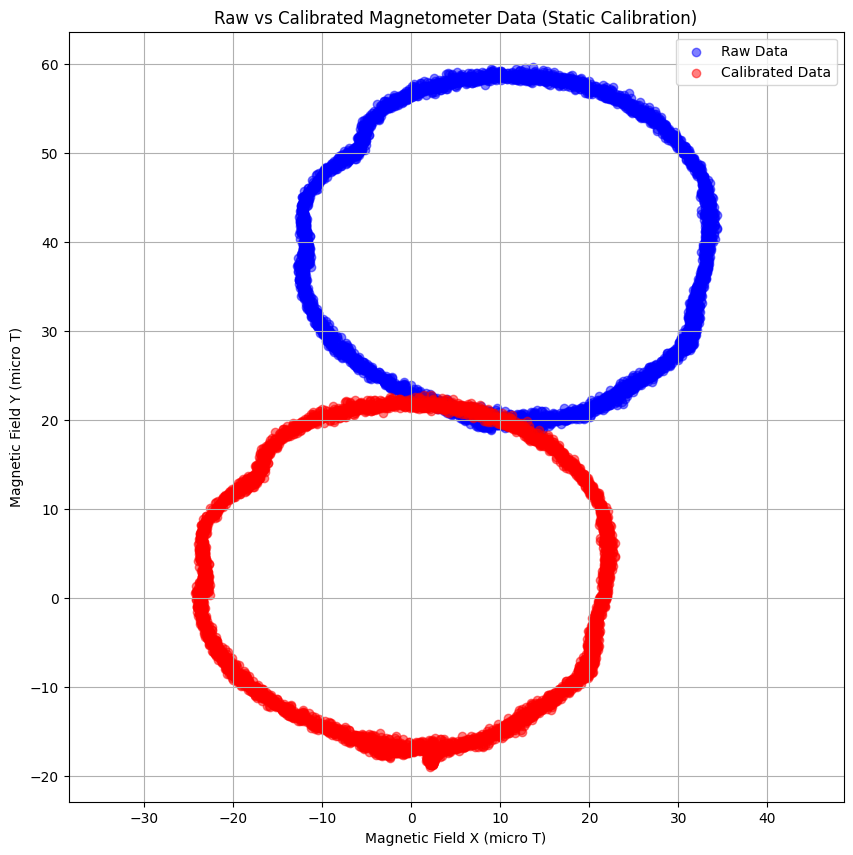

In [17]:
import rosbag2_py
from rclpy.serialization import deserialize_message
import numpy as np
import matplotlib.pyplot as plt
from rosidl_runtime_py.utilities import get_message

class MagnetometerCalibrator:
    def __init__(self):
        self.mag_data = []
    
    def read_rosbag(self, bag_path: str) -> None:
        """
        Read magnetometer data from a ROS2 bag file.
        Handles custom IMU message format with magnetic field data.
        """
        storage_options = rosbag2_py.StorageOptions(
            uri=bag_path,
            storage_id='sqlite3'
        )
        converter_options = rosbag2_py.ConverterOptions(
            input_serialization_format='cdr',
            output_serialization_format='cdr'
        )
        
        reader = rosbag2_py.SequentialReader()
        reader.open(storage_options, converter_options)
        
        topic_types = reader.get_all_topics_and_types()
        type_map = {topic_types[i].name: topic_types[i].type for i in range(len(topic_types))}
        
        while reader.has_next():
            topic_name, data, timestamp = reader.read_next()
            
            if '/imu' in topic_name:  # Adjust this to match your IMU topic name
                msg_type = type_map[topic_name]
                msg_class = get_message(msg_type)
                imu_msg = deserialize_message(data, msg_class)
                
                try:
                    mag_data = np.array([
                        imu_msg.mag_field.magnetic_field.x,
                        imu_msg.mag_field.magnetic_field.y,
                        imu_msg.mag_field.magnetic_field.z
                    ])
                    
                    if not np.any(np.isnan(mag_data)) and not np.any(np.isinf(mag_data)):
                        self.mag_data.append(mag_data)
                except AttributeError as e:
                    print(f"Error accessing magnetic field data: {e}")
                    raise
        
        self.mag_data = np.array(self.mag_data)
        # Convert from Tesla to millitesla
        self.mag_data *= 1e6  # 1 Tesla = 1e6 microtesla
        print(f"Loaded {len(self.mag_data)} valid magnetic field measurements")

    def static_calibration(self) -> tuple:
        """
        Perform static magnetometer calibration by calculating bias and scale.
        Returns: (bias, scale) tuple
        """
        bias = np.mean(self.mag_data, axis=0)
        scale = np.array([1.0, 1.0, 1.0])  # Assuming no scaling initially
        
        # Subtract bias to center the data
        calibrated_data = self.mag_data - bias
        
        # Optionally calculate scale if necessary, e.g., based on expected norm
        return bias, scale

    def plot_comparison(self, bias: np.ndarray, scale: np.ndarray) -> None:
        """
        Plot both raw and calibrated magnetometer data for comparison in a single plot.
        """
        calibrated_data = (self.mag_data - bias) * scale
        
        plt.figure(figsize=(10, 10))
        plt.scatter(
            self.mag_data[:, 0],
            self.mag_data[:, 1],
            c='b',
            alpha=0.5,
            label='Raw Data'
        )
        plt.scatter(
            calibrated_data[:, 0],
            calibrated_data[:, 1],
            c='r',
            alpha=0.5,
            label='Calibrated Data'
        )
        
        plt.title('Raw vs Calibrated Magnetometer Data (Static Calibration)')
        plt.xlabel('Magnetic Field X (micro T)')
        plt.ylabel('Magnetic Field Y (micro T)')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.show()

def main():
    calibrator = MagnetometerCalibrator()
    
    bag_path = "/home/rgautham20/lab4/data_going_in_circles.bag/data_going_in_circles.bag_0.db3"  # Update with your bag file path
    calibrator.read_rosbag(bag_path)
    
    bias, scale = calibrator.static_calibration()
    
    print("Static Calibration Results:")
    print(f"Bias: {bias}")
    print(f"Scale: {scale}")
    
    calibrator.plot_comparison(bias, scale)

if __name__ == "__main__":
    main()
